In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import collections
import pickle

In [2]:
with open('images_modified.pkl', 'rb') as file:
    traindev_authentic, traindev_copy_images, traindev_copy_masks, traindev_spliced_images, traindev_spliced_masks = pickle.load(file)

In [8]:
import cv2

def resize_images(images_list, target_size):
    resized_images = []
    for img in images_list:
        # Determine if the image needs to be enlarged or shrinked
        if img.shape[0] < target_size[0] or img.shape[1] < target_size[1]:
            interpolation = cv2.INTER_LINEAR  # Enlarging
        else:
            interpolation = cv2.INTER_AREA  # Shrinking

        # Resize the image with the appropriate interpolation method
        resized_img = cv2.resize(img, target_size, interpolation=interpolation)
        resized_images.append(resized_img)

    return resized_images

# Example usage
# Assuming you have a list of images called 'image_list'
resized_traindev_authentic = resize_images(traindev_authentic, (384,256))
resized_traindev_copy_images = resize_images(traindev_copy_images, (384,256))
resized_traindev_copy_masks = resize_images(traindev_copy_masks, (384,256))
resized_traindev_spliced_images = resize_images(traindev_spliced_images, (384,256))
resized_traindev_spliced_masks = resize_images(traindev_spliced_masks, (384,256))

In [17]:
binaries =[]
for i in resized_traindev_copy_masks:
    temp = np.copy(i)
    blur = cv2.GaussianBlur(temp,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY)
    binaries.append(th)

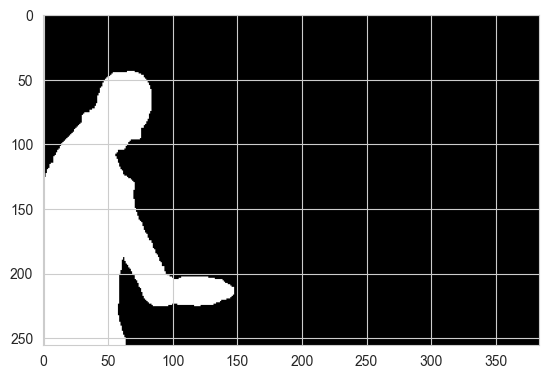

In [18]:
plt.imshow(th, cmap='gray')

In [19]:
mask_pixels = [np.count_nonzero(binaries[i]) for i in range(len(binaries))]

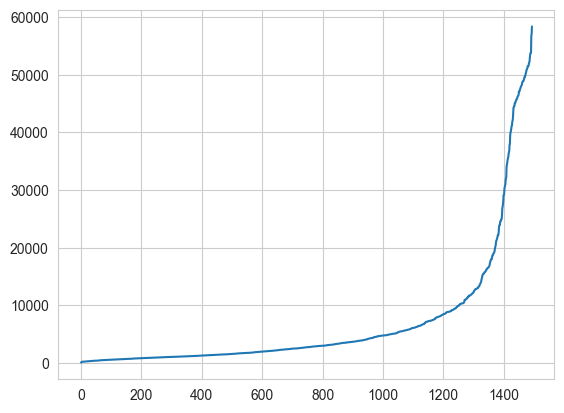

In [20]:
# rcParams['figure.figsize']=15,10
plt.plot(sorted(mask_pixels))

In [21]:
print(np.mean(np.percentile(sorted(mask_pixels), np.arange(.1,1,.1))))

224.52111111111108


In [22]:
# def count_255(mask):
#     c=0
#     for i in mask:
#         for row in i:
#             for col in row:
#                 if col==255:
#                     c+=1
#     return c

def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==1:
                i+=1
    return i

In [38]:
def sample_fake(img, mask):
    kernel_size=64
    stride=32

    samples=[]

    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):

            c_255=count_255(mask[y_start:y_start+kernel_size, x_start:x_start+kernel_size])

            if (c_255>225) and (kernel_size*kernel_size-c_255>225):
                samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])

    return samples


In [45]:
image = np.copy(resized_traindev_copy_images[45])
mask = np.copy(resized_traindev_copy_masks[45])
sample = sample_fake(image, mask)

In [46]:
len(sample)

5

In [52]:
# FOR COPY_MOVED IMAGES:
copy_lengths_each = []
samples_copy_moved=[]
i=0
ignored = 0
for fake, mask in zip(resized_traindev_copy_images, resized_traindev_copy_masks):
    image_samples=sample_fake(fake, mask)
    if len(image_samples)==0:
        ignored+=1
    else:
        copy_lengths_each.append(len(image_samples))
        for sample in image_samples:
            samples_copy_moved.append(sample)
            i+=1


In [53]:
print(ignored)

86


In [54]:
print(len(samples_copy_moved))

13037


In [55]:
print(np.mean(copy_lengths_each))

9.259232954545455


In [56]:
len(samples_copy_moved)/1494

8.72623828647925

In [57]:
with open('new_samples_copy_moved.pkl','wb') as f:
    pickle.dump(samples_copy_moved,f)

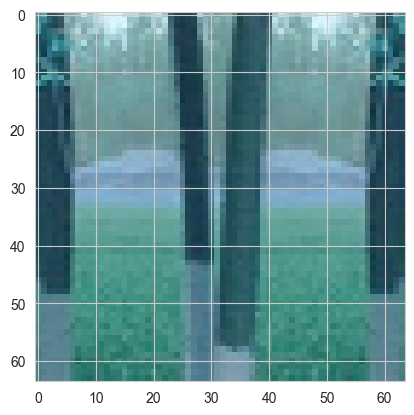

In [58]:
plt.imshow(samples_copy_moved[786])

In [59]:
# FOR SPLICED IMAGES:
spliced_lengths=[]
samples_spliced=[]
i=0
ignored = 0
for fake, mask in zip(resized_traindev_spliced_images, resized_traindev_spliced_masks):
    image_samples=sample_fake(fake, mask)
    if len(image_samples)==0:
        ignored+=1
    else:
        spliced_lengths.append(len(image_samples))
        for sample in image_samples:
            samples_spliced.append(sample)
            i+=1

In [60]:
print(len(samples_spliced))

24128


In [61]:
print(ignored)

29


In [62]:
print(np.mean(spliced_lengths))

16.46962457337884


In [63]:
len(samples_spliced)/1494

16.149933065595715

In [64]:
with open('new_samples_spliced.pkl','wb') as f:
    pickle.dump(samples_spliced,f)

In [171]:
import joblib

fname = 'samples_spliced_64_16.pkl'
joblib.dump(samples_spliced, fname)

['samples_spliced_64_16.pkl']

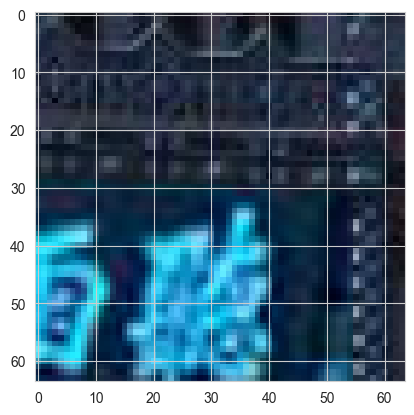

In [66]:
plt.imshow(samples_spliced[5])

CREATING SAMPLES FOR AUTHENTIC IMAGES:

In [67]:
def sample_random(img, num_samples, stride=32):
    kernel_size=64

    x_start=0
    y_start=0
    samples=[]

    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):

            #c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])

            #if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])


    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))

    sampled=[]
    for i in indices:
        sampled.append(samples[i])

    return sampled

In [70]:
1494*9

13446

In [73]:
i=0
samples_authentic = []
for auth_img in resized_traindev_authentic:
    samples=sample_random(auth_img, 9)
    for sample in samples:
        samples_authentic.append(sample)
        i+=1
print(i)

13446


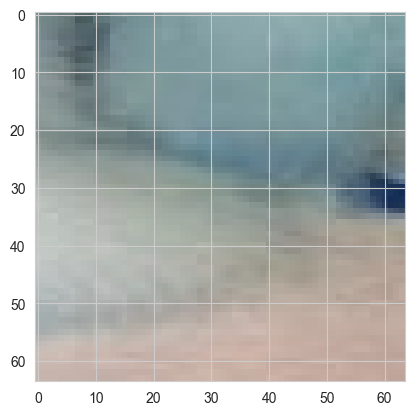

In [74]:
plt.imshow(samples_authentic[4])

In [75]:
with open('new_samples_authentic.pkl', 'wb') as file:
    pickle.dump(samples_authentic, file)

In [190]:
len(samples_copy_moved) + len(samples_spliced)

155652

In [191]:
len(samples_authentic)

59760

In [192]:
samples_forged_all = samples_copy_moved + samples_spliced

In [194]:
train_labels=[0]*len(samples_authentic)+[1]*len(samples_forged_all)

In [204]:
train_data = samples_authentic + samples_forged_all

In [205]:
len(train_data)

215412

In [206]:
with open('train_data.pkl', 'wb') as file:
    pickle.dump((train_data, train_labels), file)

MemoryError: 